In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

In [4]:
data = pd.read_csv('./data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


KeyError: 'quality'

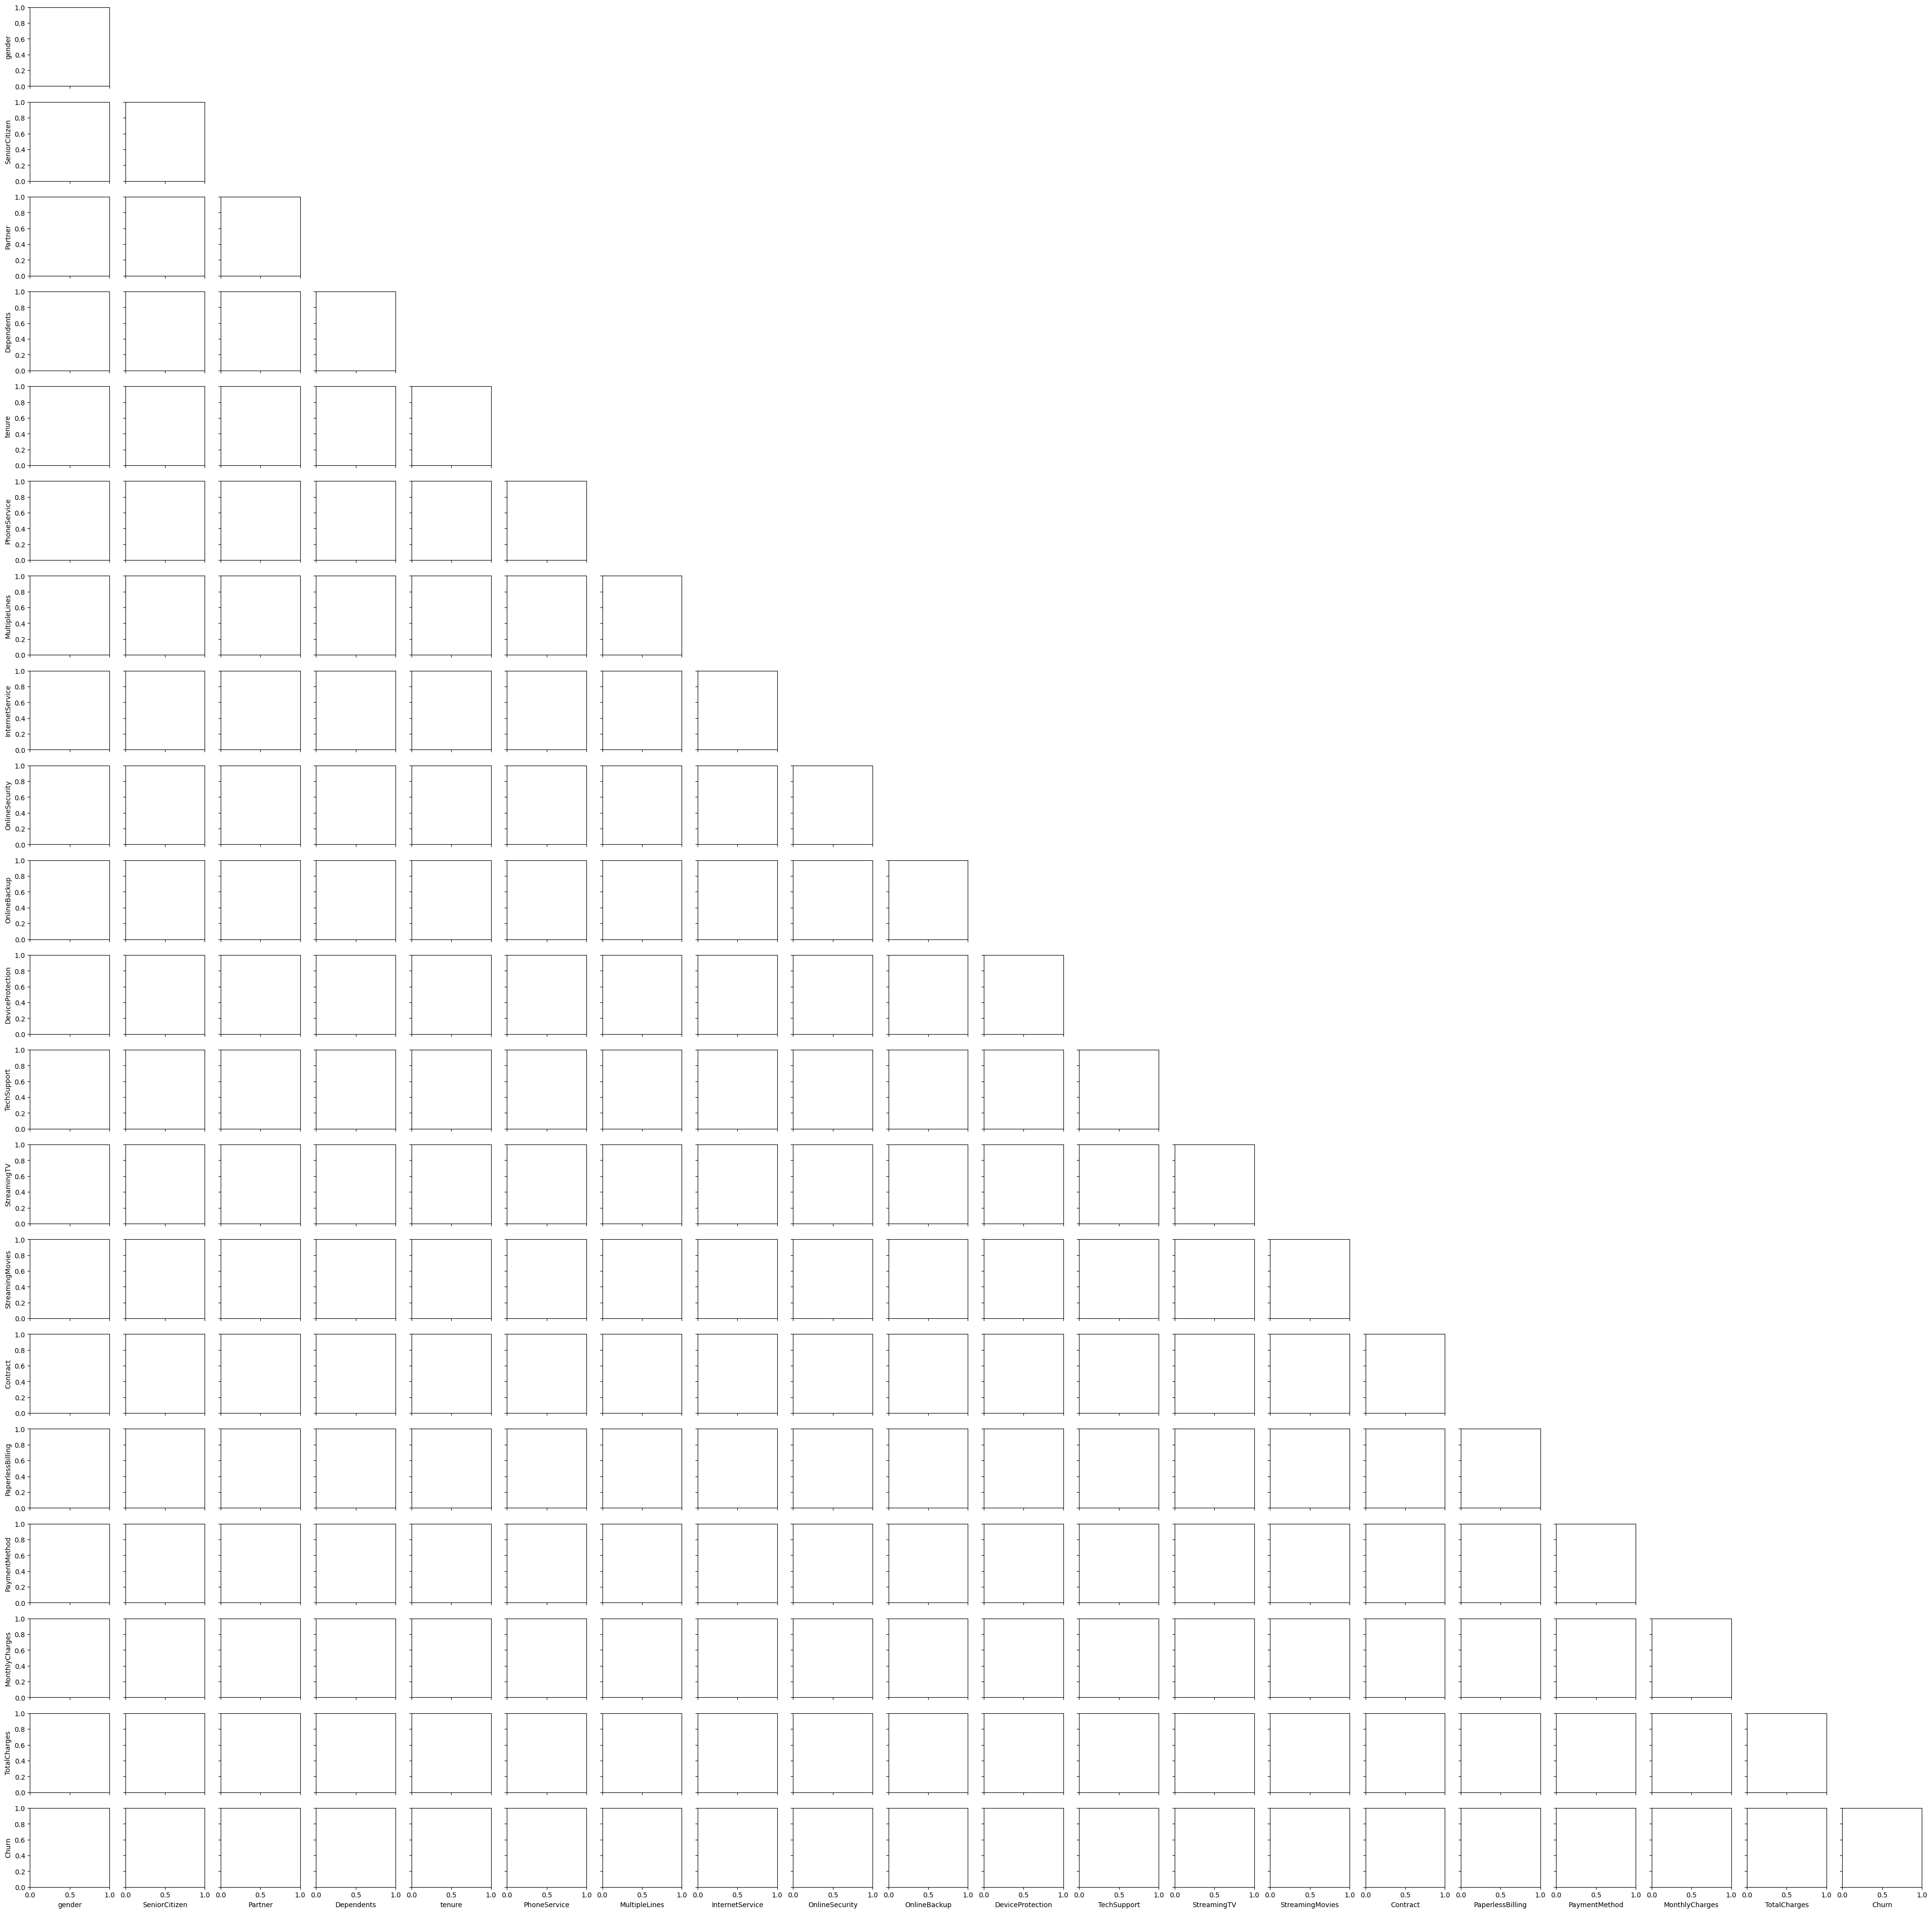

In [18]:
sns.pairplot(data, hue='gender', corner=True)
plt.show()

In [5]:
# Preprocessing
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].mean(), inplace=True)

for column in data.select_dtypes(include=['object']):
    if column != 'customerID':
        data[column] = LabelEncoder().fit_transform(data[column])

In [6]:
# Splitting dataset
X = data.drop(['customerID', 'Churn'], axis=1)
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
# Scaling features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# Training and evaluating models
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_preds = logreg.predict(X_test)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

In [9]:
# Metrics
logreg_accuracy = accuracy_score(y_test, logreg_preds)
logreg_precision = precision_score(y_test, logreg_preds)
logreg_recall = recall_score(y_test, logreg_preds)
logreg_f1 = f1_score(y_test, logreg_preds)

rf_accuracy = accuracy_score(y_test, rf_preds)
rf_precision = precision_score(y_test, rf_preds)
rf_recall = recall_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds)



print(f"Logistic Regression - Accuracy: {logreg_accuracy}, Precision: {logreg_precision}, Recall: {logreg_recall}, F1: {logreg_f1}")
print(f"Random Forest - Accuracy: {rf_accuracy}, Precision: {rf_precision}, Recall: {rf_recall}, F1: {rf_f1}")

Logistic Regression - Accuracy: 0.8106956933270232, Precision: 0.68125, Recall: 0.5696864111498258, F1: 0.6204933586337761
Random Forest - Accuracy: 0.7983909133932797, Precision: 0.6822660098522167, Recall: 0.48257839721254353, F1: 0.5653061224489795


In [10]:
# Hyperparameter tuning
param_grid = {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

In [11]:
# Feature selection
rfe = RFE(RandomForestClassifier(**best_params), n_features_to_select=10)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

rf_optimized = RandomForestClassifier(**best_params)
rf_optimized.fit(X_train_rfe, y_train)
rf_optimized_preds = rf_optimized.predict(X_test_rfe)

rf_optimized_accuracy = accuracy_score(y_test, rf_optimized_preds)
rf_optimized_precision = precision_score(y_test, rf_optimized_preds)
rf_optimized_recall = recall_score(y_test, rf_optimized_preds)
rf_optimized_f1 = f1_score(y_test, rf_optimized_preds)

print(f"Optimized Random Forest - Accuracy: {rf_optimized_accuracy}, Precision: {rf_optimized_precision}, Recall: {rf_optimized_recall}, F1: {rf_optimized_f1}")


Optimized Random Forest - Accuracy: 0.7927117841930904, Precision: 0.6497797356828194, Recall: 0.5139372822299652, F1: 0.5739299610894941


In [12]:


#Identifying important features
important_features = pd.Series(rf_optimized.feature_importances_, index=X.columns[rfe.support_])
important_features = important_features.sort_values(ascending=False)

print("\nImportant Features:")
print(important_features)



Important Features:
TotalCharges        0.197087
MonthlyCharges      0.194294
tenure              0.172312
Contract            0.143837
OnlineSecurity      0.089775
TechSupport         0.066523
PaymentMethod       0.049406
InternetService     0.033811
OnlineBackup        0.026621
PaperlessBilling    0.026333
dtype: float64


In [13]:
#Conclusion
print("\nBased on the evaluation metrics, the Optimized Random Forest model is the best-performing model.")
print("The top features contributing to customer churn prediction are:")
print(important_features.head(5))


Based on the evaluation metrics, the Optimized Random Forest model is the best-performing model.
The top features contributing to customer churn prediction are:
TotalCharges      0.197087
MonthlyCharges    0.194294
tenure            0.172312
Contract          0.143837
OnlineSecurity    0.089775
dtype: float64
